# RegVelo inferred latent time is continues

## Library imports

In [1]:
import os
import sys
from tqdm import tqdm
import random

import tensorflow
import numpy as np
import pandas as pd
import torch
from scipy.stats import pearsonr, spearmanr, ttest_ind
from sklearn.metrics import accuracy_score
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib.colors import to_hex
from scipy.stats import wilcoxon
from sklearn.metrics.pairwise import cosine_similarity

import scanpy as sc
import scvelo as scv
import scvi
from scvelo.plotting.simulation import compute_dynamics

# from _calculation import get_gams
sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR

2024-08-30 11:41:35.252569: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 11:41:35.779887: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 11:41:35.780088: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 11:41:35.781600: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 11:41:36.014640: I tensorflow/core/platform/cpu_feature_g

In [2]:
from regvelovi import REGVELOVI
from typing import Literal
from velovi import preprocess_data, VELOVI
import anndata

In [3]:
import scipy
import sklearn
import unitvelo as utv
import re

import torch.nn.functional as F
from scipy.spatial.distance import cdist

(Running UniTVelo 0.2.5.2)
2024-08-30 09:43:34


## General settings

In [4]:
scvi.settings.dl_pin_memory_gpu_training = False

In [5]:
plt.rcParams["svg.fonttype"] = "none"

In [6]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

In [7]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "cell_cycle", exist_ok=True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / "cell_cycle", exist_ok=True)

## Function definitions

### Note:
##### The function `add_significance`, `get_significance`, `add_regvelo_outputs_to_adata`, `compute_confidence`, `fit_velovi` are adapted on an an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository: https://github.com/YosefLab/velovi_reproducibility with License: BSD-3-Clause license

In [8]:
def add_significance(ax, left: int, right: int, significance: str, level: int = 0, **kwargs):
    """
    Add a significance bracket and label to a plot.

    Parameters:
    ax : matplotlib.axes.Axes
        The axes to add the significance to.
    left : int
        The x-coordinate for the left end of the bracket.
    right : int
        The x-coordinate for the right end of the bracket.
    significance : str
        The significance label to display.
    level : int, optional
        The level for bracket positioning (default is 0).
    **kwargs :
        Additional plotting arguments for customization.
    """

    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)

    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot([left, left, right, right], [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs)

    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha="center",
        va="bottom",
        c="k",
    )

In [9]:
def get_significance(pvalue):
    """
    Get significance level based on p-value.

    Parameters:
    pvalue : float
        The p-value to evaluate.

    Returns:
    str
        Significance level as a string: '***', '**', '*', or 'n.s.'.
    """

    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

In [10]:
def add_regvelo_outputs_to_adata(adata_raw, vae, filter=False):
    """
    Add latent time and velocity outputs from a RegVelo model to an AnnData object.

    Parameters:
    adata_raw : anndata.AnnData
        The raw AnnData object containing gene expression data.
    vae : object
        A RegVelo model instance used for calculating latent time and velocities.
    filter : bool, optional
        Whether to apply filtering (default is False).

    Returns:
    anndata.AnnData
        The modified AnnData object with added velocity and latent time data.
    """

    latent_time = vae.get_latent_time(n_samples=30, batch_size=adata_raw.shape[0])
    velocities = vae.get_velocity(n_samples=30, batch_size=adata_raw.shape[0])

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:, vae.module.target_index].copy()

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_regvelo"] = latent_time

    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var["fit_scaling"] = 1.0

    ## calculate likelihood

    return adata

In [12]:
def compute_confidence(adata, vkey="velocity"):
    """
    Compute the confidence of velocity estimates in an AnnData object.

    Parameters:
    adata : anndata.AnnData
        The AnnData object containing velocity data in its layers.
    vkey : str, optional
        The key in the layers to access velocity data (default is "velocity").

    Returns:
    pandas.DataFrame
        A DataFrame containing the latent time consistency values.
    """

    velo = adata.layers[vkey]
    scv.tl.velocity_graph(adata, vkey=vkey, n_jobs=1)
    scv.tl.velocity_confidence(adata, vkey=vkey)

    g_df = pd.DataFrame()
    g_df["Latent time consistency"] = adata.obs[f"{vkey}_confidence"].to_numpy().ravel()

    return g_df

In [13]:
def fit_velovi(bdata):
    """
    Fit the VELOVI model to the provided AnnData object and plot training history.

    Parameters:
    bdata : anndata.AnnData
        The AnnData object containing spliced and unspliced layers for model training.

    Returns:
    VELOVI
        The trained VELOVI model instance.
    """

    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)
    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={"elbo_train": "elbo"})
    df["set"] = "train"

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={"elbo_validation": "elbo"})
    _df["set"] = "validation"

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x="epoch", y="elbo", hue="set", palette=["#0173B2", "#DE8F05"], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr).detach().cpu().numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var["fit_scaling"] = 1.0

    return vae

## Data loading

In [14]:
adata = sc.read(DATA_DIR / "cell_cycle" / "cell_cycle_processed.h5ad")
adata.uns["regulators"] = adata.var.index.values
adata.uns["targets"] = adata.var.index.values
adata.uns["skeleton"] = np.ones((len(adata.var.index), len(adata.var.index)))
adata.uns["network"] = np.ones((len(adata.var.index), len(adata.var.index)))
adata

AnnData object with n_obs × n_vars = 1146 × 395
    obs: 'phase', 'fucci_time', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'neighbors', 'pca', 'umap', 'velocity_params', 'regulators', 'targets', 'skeleton', 'network'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'velocity'
    obsp: 'connectivities', 'distances'

In [15]:
reg_vae = REGVELOVI.load(DATA_DIR / "cell_cycle" / "model_1", adata)

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/cell_cycle/model_1/model.pt    
         already downloaded                                                                                        


In [16]:
adata_target = add_regvelo_outputs_to_adata(adata, reg_vae)

## Running veloVI as baseline

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 433/500:  87%|████████▋ | 433/500 [00:38<00:05, 11.27it/s, loss=-567, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -583.197. Signaling Trainer to stop.


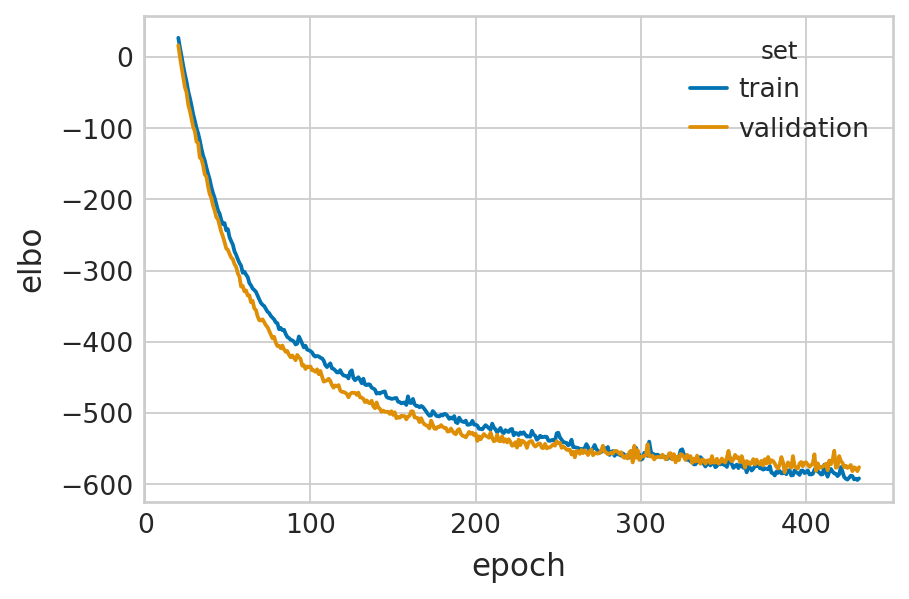

In [17]:
adata_vi = adata.copy()
velovi_vae = fit_velovi(adata_vi)

## replacing velocity as the latent time

In [18]:
dfs = []

g_df = compute_confidence(adata_target, vkey="fit_t")
g_df["Dataset"] = "Cell cycle"
g_df["Method"] = "RegVelo"
dfs.append(g_df)

g_df = compute_confidence(adata_vi, vkey="fit_t")
g_df["Dataset"] = "Cell cycle"
g_df["Method"] = "veloVI"
dfs.append(g_df)

conf_df = pd.concat(dfs, axis=0)

computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'fit_t_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'fit_t_length' (adata.obs)
--> added 'fit_t_confidence' (adata.obs)
--> added 'fit_t_confidence_transition' (adata.obs)
computing velocity graph (using 1/64 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'fit_t_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'fit_t_length' (adata.obs)
--> added 'fit_t_confidence' (adata.obs)
--> added 'fit_t_confidence_transition' (adata.obs)


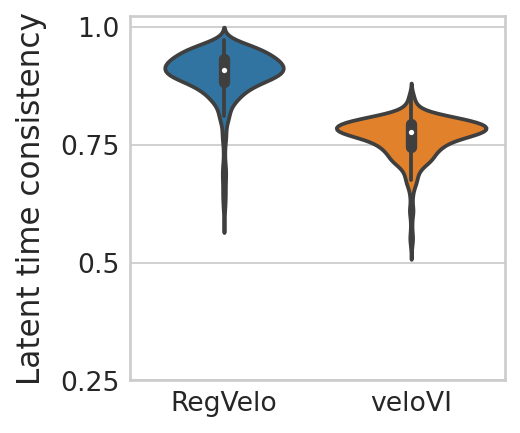

In [19]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 3))
    pal = {"RegVelo": "#f3e1eb", "veloVI": "#b5bbe3", "scVelo": "#0fcfc0"}

    sns.violinplot(
        data=conf_df,
        ax=ax,
        # orient="h",
        x="Method",
        y="Latent time consistency",
        order=["RegVelo", "veloVI"],
    )
    # plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels([0.25, 0.5, 0.75, 1.0])
    plt.xlabel("")

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "cell_cycle" / "Latent_time_consistency.svg", format="svg", transparent=True, bbox_inches="tight"
        )

## calculate fold change

In [20]:
graph = adata.obsp["connectivities"].A

In [21]:
Time_FC = []
for i in range(graph.shape[0]):
    v = adata_target[i].layers["fit_t"]
    m = adata_target[graph[i, :] != 0].layers["fit_t"]
    cos_similarities = cosine_similarity(v, m)

    ## randomly sample each number of cells
    indices = random.sample(range(0, adata.shape[0]), m.shape[0])
    m = adata_target[indices].layers["fit_t"]
    cos_similarities_random = cosine_similarity(v, m)

    FC = np.mean(cos_similarities) / np.mean(cos_similarities_random)
    Time_FC.append(FC)

In [22]:
b = np.zeros(len(Time_FC))
_, p_value = wilcoxon(Time_FC, b, alternative="greater")
p_value

2.592628865738403e-189

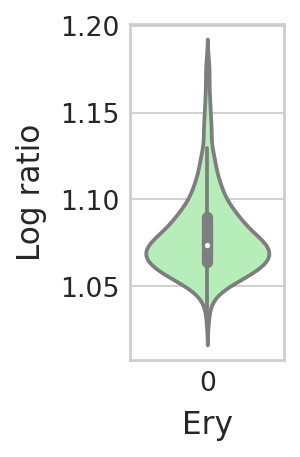

In [23]:
b = np.zeros(len(Time_FC))
_, p_value = wilcoxon(Time_FC, b, alternative="greater")
significance = get_significance(p_value)

significance_palette = {"n.s.": "#dedede", "*": "#90BAAD", "**": "#A1E5AB", "***": "#ADF6B1"}
palette2 = significance_palette[significance]

# Step 3: Create the boxplot
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, axes = plt.subplots(figsize=(2, 3))

    # Step 4: Color based on significance

    sns.violinplot(data=Time_FC, color=palette2)

    # Add titles and labels
    plt.xlabel("Ery")
    plt.ylabel("Log ratio")

    fig.tight_layout()
    plt.show()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "cell_cycle" / "Latent_time_consistency_test.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )